In [64]:
import cv2
import os
import numpy as np
from random import shuffle
from tqdm import tqdm

In [65]:
TRAIN_DIR = 'C:\\Users\\HP\\Desktop\\AI Projects\\AI Bench Press RPE Calculator\\training data'
TEST_DIR = 'C:\\Users\\HP\\Desktop\\AI Projects\\AI Bench Press RPE Calculator\\test data'
IMG_SIZE = 100
LR = 1e-7

In [66]:
# Setting up the model which will help with tensorflow models
MODEL_NAME = 'extendedvscontracted-{}-{}.model'.format(LR, '6conv-basic')

### Labelling the dataset

In [67]:

def label_img(img):

    word_label = img.split('.')[0].split("_")[0]
    
    #One hot encoder
    if word_label == 'extended':
        return [1,0]
    elif word_label == 'contracted':
        return [0,1]

### Creating the training data

In [68]:

def create_train_data():

    '''
    Creating an empty list where we should store the training data
    after a little preprocessing of the data
    '''

    training_data = []

    #tqdm is only used for interactive loading

    #loading the training data
    
    for img in tqdm(os.listdir(TRAIN_DIR)):

        #labeling the images
        label = label_img(img)


        #loading the image from the path and then converting them into
        #greyscale for easier covnet prob
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)


        #resizing the image for processing them in the covnet
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))


        #final step - forming the training data list with numpy array of the images
        training_data.append([np.array(img),np.array(label)])

    #shuffling of the training data to preserve the random state of our data
    for _ in range(5):
        shuffle(training_data)

    #saving our trained data for further uses if required
    np.save('train_data.npy', training_data)
    return training_data

### Processing the given test data

In [69]:

#Almost same as processing the traning data but
#we dont have to label it.
def process_test_data():
    testing_data = []
    for imgfile in tqdm(os.listdir(TEST_DIR)):
        img = os.path.join(TEST_DIR,imgfile)
        img_num = imgfile.split('.')[0]
        img = cv2.imread(img ,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    for _ in range(3):
        shuffle(testing_data)
        
    np.save('test_data.npy', testing_data)
    return testing_data

In [70]:
train_data = create_train_data()
test_data = process_test_data()

100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


### Creating the neural network using tensorflow

In [71]:
#Importing the required libraries
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

tf.compat.v1.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [72]:
train = train_data[:-8]
test = train_data[-8:]


### Setting up the features and labels

In [73]:

#X-Features & Y-Labels

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]
test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

### Fitting the data into our model

In [74]:
#epoch = 5 taken
model.fit({'input': X}, {'targets': Y}, n_epoch=8, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
model.save(MODEL_NAME)

---------------------------------
Run id: extendedvscontracted-1e-07-6conv-basic.model
Log directory: log/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 32
Validation samples: 8
--
Training Step: 1  | time: 4.614s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 0.69519 - val_acc: 0.5000 -- iter: 32/32
--
Training Step: 2  | total loss: 0.62241 | time: 2.849s
| Adam | epoch: 002 | loss: 0.62241 - acc: 0.5344 | val_loss: 0.69519 - val_acc: 0.5000 -- iter: 32/32
--
Training Step: 3  | total loss: 0.68233 | time: 2.388s
| Adam | epoch: 003 | loss: 0.68233 - acc: 0.5063 | val_loss: 0.69518 - val_acc: 0.5000 -- iter: 32/32
--
Training Step: 4  | total loss: 0.68809 | time: 2.415s
| Adam | epoch: 004 | loss: 0.68809 - acc: 0.5250 | val_loss: 0.69517 - val_acc: 0.5000 -- iter: 32/32
--
Training Step: 5  | total loss: 0.69368 | time: 2.500s
| Adam | epoch: 005 | loss: 0.69368 - acc: 0.507

### Testing the data

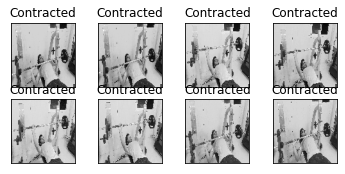

In [75]:
import matplotlib.pyplot as plt

fig=plt.figure()

for num,data in enumerate(test_data):
    # extended: [1,0]
    # contracted: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    reshaped_data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_pred = model.predict([reshaped_data])[0]
    
    if np.argmax(model_pred) == 1:
        str_label='Contracted'
    else:
        str_label='Extended'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()